In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
#from torchvision.models import resnet18, resnet18, ResNet18_Weights
import torch.nn.functional as F

import tqdm.notebook as tqdm
from functools import partial
import time

#from google.colab import files

import resnet
import resnet_m

In [14]:
transform_train = transforms.Compose(
    [transforms.RandomCrop(32, padding=4, fill=128),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(30),
     transforms.ToTensor(),
     transforms.Normalize(
         mean=(0.4914, 0.4822, 0.4465),
         std=(0.2023, 0.1994, 0.2010))]
)

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(
         mean=(0.4914, 0.4822, 0.4465),
         std=(0.2023, 0.1994, 0.2010))]
)

In [15]:
batch_size = 32

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size,
    shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size,
    shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [16]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
    
print(type(device), device)

<class 'torch.device'> cuda:0


In [17]:
model18 = resnet.resnet18(n_classes=10, width_decrement=2)
model18.load_state_dict(torch.load('model18_weights_best.pt'))
model18.eval()

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (relu): ReLU(inplace=True)
      (blocks): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (relu): ReLU(inplace=True)
      (blocks): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [19]:
model18.to(device)

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (relu): ReLU(inplace=True)
      (blocks): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (relu): ReLU(inplace=True)
      (blocks): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [20]:
model6 = resnet_m.resnet6(n_classes=10, width_decrement=2)
model6.to(device)

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (relu): ReLU(inplace=True)
      (blocks): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (relu): ReLU(inplace=True)
      (blocks): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [21]:
def KDLoss(x, labels, temperature=3.0):
    log_softmax_outputs = F.log_softmax(x/temperature, dim=1)
    softmax_targets = F.softmax(labels/temperature, dim=1)
    return -(log_softmax_outputs * softmax_targets).sum(dim=1).mean()

In [22]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=0.0001, weight_decay=5e-4)

In [23]:
def training_loop(n_epochs, teacher, student, loss_fn, optimizer, dl_train, dl_test, device, ce_coef=0.3):
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    last_loss = 100
    patience = 3
    trigger_times = 0
    best_acc = 75
    pbar = tqdm.tqdm(range(n_epochs), total=n_epochs, leave=False)
    for epoch in pbar:
        # Переводим сеть в режим обучения
        student.train(True)

        # Итерация обучения сети
        for images, labels in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = student(images)
            teacher_output = teacher(images)
            loss = (1 - ce_coef) * loss_fn(outputs, labels)
            loss += ce_coef * KDLoss(outputs, teacher_output)
            loss.backward()
            optimizer.step()
        
        # Оцениваем качество модели каждые 3 итерации
        if epoch % 3 == 0 or epoch == n_epochs - 1:
            student.eval()

            with torch.no_grad():
                # Вычисление качества и функции потерь на обучающей выборке
                train_l = 0.
                train_ac = 0.
                total_train=len(dl_train)
                for images, labels in iter(dl_train):
                    images, labels = images.to(device), labels.to(device)
                    train_output = student(images)
                    teacher_output = teacher(images)
                    train_l += (1 - ce_coef) * loss_fn(train_output, labels)
                    train_l += ce_coef * KDLoss(train_output, teacher_output)
                    train_pred = train_output.argmax(axis = 1)
                    train_ac += (train_pred == labels).float().sum() / images.shape[0] * 100.
                train_accuracies.append(train_ac/total_train)
                train_losses.append(train_l/total_train)
                # Вычисление качества и функции потерь на тестовой выборке
                test_l = 0.
                test_ac = 0.
                total_test = len(dl_test)
                for images, labels in iter(dl_test):
                    images, labels = images.to(device), labels.to(device)
                    test_output = student(images)
                    teacher_output = teacher(images)
                    test_l += (1 - ce_coef) * loss_fn(test_output, labels)
                    test_l += ce_coef * KDLoss(test_output, teacher_output)
                    test_pred = test_output.argmax(axis = 1)
                    test_ac += (test_pred == labels).float().sum() / images.shape[0] * 100.
                test_accuracies.append(test_ac/total_test)
                test_losses.append(test_l/total_test)
            #early stopping
            if test_losses[-1] > last_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f'Early stopping at epoch {epoch}')
                    break
            else:
                trigger_times = 0
            last_loss = test_losses[-1]

            #сохранение лучшей модели
            if test_accuracies[-1] > best_acc:
                state_dict = model6.state_dict()
                torch.save(state_dict, 'model6_weights.pt')
                #files.download('model18_weights.pt')
                best_acc = test_accuracies[-1]
            
            pbar.set_description(
                'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}\n'.format(
                    train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                )
            )
            print('Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}\n'.format(
                    train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                ))
            
    return train_losses, test_losses, train_accuracies, test_accuracies

In [24]:
start = time.time()
n_epochs = 600
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=n_epochs, teacher=model18, student=model6, loss_fn=loss_fn, 
    optimizer=optimizer, dl_train=trainloader, dl_test=testloader, device=device
)
ex_time = time.time() - start

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.729/1.670. Accuracy, % (Train/Test): 44.76/45.41



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.422/1.320. Accuracy, % (Train/Test): 56.00/59.40



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.300/1.192. Accuracy, % (Train/Test): 61.53/65.05



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.232/1.136. Accuracy, % (Train/Test): 64.49/67.56



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.176/1.092. Accuracy, % (Train/Test): 66.99/69.18



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.176/1.080. Accuracy, % (Train/Test): 66.69/69.66



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.118/1.022. Accuracy, % (Train/Test): 69.63/72.30



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.068/0.979. Accuracy, % (Train/Test): 71.56/74.52



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.049/0.960. Accuracy, % (Train/Test): 72.53/75.00



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.032/0.950. Accuracy, % (Train/Test): 73.74/75.78



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 1.002/0.934. Accuracy, % (Train/Test): 74.57/76.48



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.989/0.907. Accuracy, % (Train/Test): 75.58/77.96



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.979/0.915. Accuracy, % (Train/Test): 75.91/76.76



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.957/0.881. Accuracy, % (Train/Test): 76.78/78.36



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.934/0.870. Accuracy, % (Train/Test): 77.76/78.97



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.931/0.858. Accuracy, % (Train/Test): 77.95/79.33



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.925/0.859. Accuracy, % (Train/Test): 78.38/79.81



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.901/0.843. Accuracy, % (Train/Test): 79.24/80.22



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.890/0.835. Accuracy, % (Train/Test): 79.72/81.11



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.887/0.843. Accuracy, % (Train/Test): 80.06/80.31



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.892/0.832. Accuracy, % (Train/Test): 79.63/80.76



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.869/0.824. Accuracy, % (Train/Test): 80.74/81.28



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.858/0.830. Accuracy, % (Train/Test): 81.35/80.85



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.860/0.821. Accuracy, % (Train/Test): 81.12/81.33



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.847/0.819. Accuracy, % (Train/Test): 81.89/81.85



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.835/0.810. Accuracy, % (Train/Test): 82.28/81.60



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.844/0.820. Accuracy, % (Train/Test): 81.96/81.48



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.840/0.804. Accuracy, % (Train/Test): 82.01/82.58



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.815/0.794. Accuracy, % (Train/Test): 83.33/82.55



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.811/0.787. Accuracy, % (Train/Test): 83.50/82.84



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.803/0.786. Accuracy, % (Train/Test): 83.58/82.83



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.813/0.793. Accuracy, % (Train/Test): 83.43/82.49



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.794/0.780. Accuracy, % (Train/Test): 84.17/83.39



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.808/0.789. Accuracy, % (Train/Test): 83.47/82.67



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.790/0.778. Accuracy, % (Train/Test): 84.49/83.14



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.788/0.782. Accuracy, % (Train/Test): 84.54/83.15



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.776/0.768. Accuracy, % (Train/Test): 85.23/83.74



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.772/0.781. Accuracy, % (Train/Test): 85.40/83.30



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.776/0.773. Accuracy, % (Train/Test): 85.01/83.54



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.770/0.781. Accuracy, % (Train/Test): 85.27/83.14



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.768/0.772. Accuracy, % (Train/Test): 85.48/83.38



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.773/0.786. Accuracy, % (Train/Test): 85.20/82.71



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.751/0.758. Accuracy, % (Train/Test): 86.29/83.93



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.764/0.782. Accuracy, % (Train/Test): 85.74/82.93



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.758/0.774. Accuracy, % (Train/Test): 86.11/83.74



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.746/0.758. Accuracy, % (Train/Test): 86.51/84.16



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.748/0.770. Accuracy, % (Train/Test): 86.57/83.54



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.758/0.764. Accuracy, % (Train/Test): 85.89/84.06



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.735/0.750. Accuracy, % (Train/Test): 86.92/84.43



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.733/0.754. Accuracy, % (Train/Test): 87.18/84.34



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.733/0.771. Accuracy, % (Train/Test): 87.20/83.57



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.731/0.750. Accuracy, % (Train/Test): 87.35/84.43



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.736/0.750. Accuracy, % (Train/Test): 87.11/84.57



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss (Train/Test): 0.726/0.750. Accuracy, % (Train/Test): 87.57/84.73



  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Early stopping at epoch 162


In [25]:
state_dict = model6.state_dict()
torch.save(state_dict, 'model6_weights_final.pt')

In [27]:
torch.save(torch.tensor(train_accs).cpu(), 'train_accs6.pt')
print(train_accs)

[tensor(44.7597, device='cuda:0'), tensor(56.0021, device='cuda:0'), tensor(61.5283, device='cuda:0'), tensor(64.4914, device='cuda:0'), tensor(66.9926, device='cuda:0'), tensor(66.6927, device='cuda:0'), tensor(69.6337, device='cuda:0'), tensor(71.5551, device='cuda:0'), tensor(72.5308, device='cuda:0'), tensor(73.7444, device='cuda:0'), tensor(74.5701, device='cuda:0'), tensor(75.5758, device='cuda:0'), tensor(75.9057, device='cuda:0'), tensor(76.7754, device='cuda:0'), tensor(77.7551, device='cuda:0'), tensor(77.9491, device='cuda:0'), tensor(78.3849, device='cuda:0'), tensor(79.2426, device='cuda:0'), tensor(79.7165, device='cuda:0'), tensor(80.0584, device='cuda:0'), tensor(79.6305, device='cuda:0'), tensor(80.7362, device='cuda:0'), tensor(81.3480, device='cuda:0'), tensor(81.1200, device='cuda:0'), tensor(81.8898, device='cuda:0'), tensor(82.2837, device='cuda:0'), tensor(81.9598, device='cuda:0'), tensor(82.0098, device='cuda:0'), tensor(83.3333, device='cuda:0'), tensor(83.503

In [28]:
torch.save(torch.tensor(test_accs).cpu(), 'test_accs6.pt')
print(test_accs)

[tensor(45.4073, device='cuda:0'), tensor(59.4049, device='cuda:0'), tensor(65.0459, device='cuda:0'), tensor(67.5619, device='cuda:0'), tensor(69.1793, device='cuda:0'), tensor(69.6585, device='cuda:0'), tensor(72.3043, device='cuda:0'), tensor(74.5208, device='cuda:0'), tensor(75., device='cuda:0'), tensor(75.7788, device='cuda:0'), tensor(76.4776, device='cuda:0'), tensor(77.9553, device='cuda:0'), tensor(76.7572, device='cuda:0'), tensor(78.3646, device='cuda:0'), tensor(78.9736, device='cuda:0'), tensor(79.3331, device='cuda:0'), tensor(79.8123, device='cuda:0'), tensor(80.2216, device='cuda:0'), tensor(81.1102, device='cuda:0'), tensor(80.3115, device='cuda:0'), tensor(80.7608, device='cuda:0'), tensor(81.2800, device='cuda:0'), tensor(80.8506, device='cuda:0'), tensor(81.3299, device='cuda:0'), tensor(81.8490, device='cuda:0'), tensor(81.5994, device='cuda:0'), tensor(81.4796, device='cuda:0'), tensor(82.5779, device='cuda:0'), tensor(82.5479, device='cuda:0'), tensor(82.8375, d

In [29]:
torch.save(torch.tensor(train_losses).cpu(), 'train_losses6.pt')
print(train_losses)

[tensor(1.7293, device='cuda:0'), tensor(1.4219, device='cuda:0'), tensor(1.3000, device='cuda:0'), tensor(1.2318, device='cuda:0'), tensor(1.1759, device='cuda:0'), tensor(1.1764, device='cuda:0'), tensor(1.1182, device='cuda:0'), tensor(1.0681, device='cuda:0'), tensor(1.0492, device='cuda:0'), tensor(1.0319, device='cuda:0'), tensor(1.0018, device='cuda:0'), tensor(0.9886, device='cuda:0'), tensor(0.9789, device='cuda:0'), tensor(0.9571, device='cuda:0'), tensor(0.9337, device='cuda:0'), tensor(0.9310, device='cuda:0'), tensor(0.9249, device='cuda:0'), tensor(0.9015, device='cuda:0'), tensor(0.8898, device='cuda:0'), tensor(0.8865, device='cuda:0'), tensor(0.8923, device='cuda:0'), tensor(0.8686, device='cuda:0'), tensor(0.8579, device='cuda:0'), tensor(0.8598, device='cuda:0'), tensor(0.8469, device='cuda:0'), tensor(0.8353, device='cuda:0'), tensor(0.8435, device='cuda:0'), tensor(0.8405, device='cuda:0'), tensor(0.8152, device='cuda:0'), tensor(0.8113, device='cuda:0'), tensor(0.

In [30]:
torch.save(torch.tensor(test_losses).cpu(), 'test_losses6.pt')
print(test_losses)

[tensor(1.6701, device='cuda:0'), tensor(1.3199, device='cuda:0'), tensor(1.1922, device='cuda:0'), tensor(1.1358, device='cuda:0'), tensor(1.0917, device='cuda:0'), tensor(1.0800, device='cuda:0'), tensor(1.0224, device='cuda:0'), tensor(0.9789, device='cuda:0'), tensor(0.9601, device='cuda:0'), tensor(0.9499, device='cuda:0'), tensor(0.9337, device='cuda:0'), tensor(0.9071, device='cuda:0'), tensor(0.9150, device='cuda:0'), tensor(0.8806, device='cuda:0'), tensor(0.8698, device='cuda:0'), tensor(0.8576, device='cuda:0'), tensor(0.8593, device='cuda:0'), tensor(0.8432, device='cuda:0'), tensor(0.8346, device='cuda:0'), tensor(0.8428, device='cuda:0'), tensor(0.8324, device='cuda:0'), tensor(0.8235, device='cuda:0'), tensor(0.8304, device='cuda:0'), tensor(0.8206, device='cuda:0'), tensor(0.8192, device='cuda:0'), tensor(0.8104, device='cuda:0'), tensor(0.8204, device='cuda:0'), tensor(0.8035, device='cuda:0'), tensor(0.7937, device='cuda:0'), tensor(0.7872, device='cuda:0'), tensor(0.

In [31]:
print(ex_time)

7995.504917383194


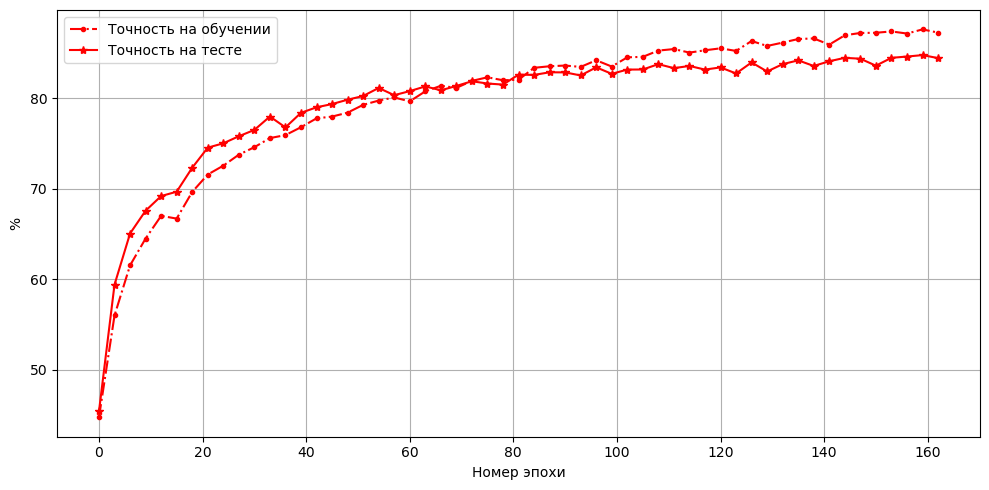

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
idx = [i for i in range(0, len(test_accs)*3, 3)]
ax.plot(idx, torch.tensor(train_accs).cpu(), label="Точность на обучении", color='red', marker='.', linestyle='-.')
ax.plot(idx, torch.tensor(test_accs).cpu(), label="Точность на тесте", color='red', marker='*')

ax.set_xlabel("Номер эпохи")
ax.set_ylabel("$\%$")

ax.grid(True)
ax.legend()


fig.tight_layout()
plt.show()

